In [1]:
#Data Process And save
from numpy.core.fromnumeric import shape
import librosa
import pathlib
import numpy as np
import pandas as pd
import csv
# import pywt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf

def get_cwt_mel(path, n_fft, hop_length, n_mels):
    sr = 16000
    duration = 8
    sample_size = sr * duration
    
    y, sr = librosa.load(path, sr=sr, duration=duration)
    file_length = np.size(y)
    
    if file_length < sample_size:
        y = np.concatenate((y, np.zeros(sample_size-file_length)), axis=0)
    else:
        y=y[0:sample_size]

    #mel_spectrogram = librosa.feature.melspectrogram(y, sr, n_fft=2048, hop_length=1001, n_mels=128)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=501,n_mfcc=128)
    stft = np.abs(librosa.stft(y,n_fft=254, hop_length=501))
    chroma=librosa.feature.chroma_stft(S=stft,n_chroma=128)
    log_mel_spectrogram = np.concatenate((stft,mfcc,chroma), axis=1)
    log_mel_spectrogram = log_mel_spectrogram.reshape((-1,))
    return log_mel_spectrogram

def classify_files(path):
    dataset_dict = {
        'total': 0,
        'file_dict': {
            'ANGRY': {'represent': 0, 'count': 0, 'all_data': []},
            'HAPPY': {'represent': 1, 'count': 0, 'all_data': []},
            'NEUTRAL': {'represent': 2, 'count': 0, 'all_data': []},
            'SAD': {'represent': 3, 'count': 0, 'all_data': []},
            'SURPRISE': {'represent': 4, 'count': 0, 'all_data': []}
            # 'DISGUST': {'represent': 1, 'count': 0, 'all_data': []},
            # 'FEAR': {'represent': 5, 'count': 0, 'all_data': []},
        }
    }    

   
    wav_path = pathlib.Path(path)
    emotion_file_list = [str(file_name) for file_name in wav_path.glob('*.wav')]

    p = len(str(wav_path))

    emotion_label_list = dataset_dict['file_dict'].keys()

    for emotion_label in emotion_label_list:
        emotion_classify_file_list = [letter for letter in emotion_file_list if letter.find(emotion_label)!=-1]

        print(emotion_classify_file_list)
        files_count = len(emotion_classify_file_list)

        dataset_dict['file_dict'][emotion_label]['count'] = files_count
        dataset_dict['total'] = dataset_dict['total'] + files_count
        
        emotion_data = [get_cwt_mel(path, n_fft=2048, hop_length=512, n_mels=128)

        
        for path in emotion_classify_file_list]
        dataset_dict['file_dict'][emotion_label]['all_data'] = emotion_data 

    return dataset_dict

path = './data/SUST'
dataset_dict = classify_files(path)

['data\\SUST\\F_02_MONIKA_S_2_ANGRY_2.wav', 'data\\SUST\\F_02_MONIKA_S_2_ANGRY_3.wav', 'data\\SUST\\F_02_MONIKA_S_2_ANGRY_4.wav', 'data\\SUST\\F_02_MONIKA_S_2_ANGRY_5.wav', 'data\\SUST\\F_02_MONIKA_S_3_ANGRY_2.wav', 'data\\SUST\\F_02_MONIKA_S_3_ANGRY_3.wav', 'data\\SUST\\F_02_MONIKA_S_3_ANGRY_5.wav', 'data\\SUST\\F_04_SWARNALI_S_9_ANGRY_1.wav', 'data\\SUST\\F_04_SWARNALI_S_9_ANGRY_2.wav', 'data\\SUST\\F_04_SWARNALI_S_9_ANGRY_3.wav', 'data\\SUST\\F_05_MOUNI_S_6_ANGRY_1.wav', 'data\\SUST\\F_05_MOUNI_S_6_ANGRY_3.wav', 'data\\SUST\\F_05_MOUNI_S_6_ANGRY_4.wav', 'data\\SUST\\F_05_MOUNI_S_6_ANGRY_5.wav', 'data\\SUST\\F_05_MOUNI_S_7_ANGRY_1.wav', 'data\\SUST\\F_05_MOUNI_S_7_ANGRY_3.wav', 'data\\SUST\\F_05_MOUNI_S_7_ANGRY_4.wav', 'data\\SUST\\F_05_MOUNI_S_8_ANGRY_2.wav', 'data\\SUST\\F_05_MOUNI_S_8_ANGRY_4.wav', 'data\\SUST\\F_05_MOUNI_S_9_ANGRY_1.wav', 'data\\SUST\\F_05_MOUNI_S_9_ANGRY_2.wav', 'data\\SUST\\F_05_MOUNI_S_9_ANGRY_3.wav', 'data\\SUST\\F_05_MOUNI_S_9_ANGRY_4.wav', 'data\\SUST\\F_06

In [2]:
#save the contents of the dictionary to a csv file
def save_dict_to_csv(dict, file_name):
    with open(file_name, 'w') as f:
        writer = csv.writer(f)
        for key, value in dict.items():
            writer.writerow([key, value])
            
save_dict_to_csv(dataset_dict, 'saved/dataset_dict_SUST.csv')

#load the contents of the dictionary from a csv file
def load_dict_from_csv(file_name):
    with open(file_name, 'r') as f:
        reader = csv.reader(f)
        dict = dict(reader)
    return dict

In [3]:

def load_data(path):
    train_data_x = []
    train_data_y = []
    validation_data_x = []
    validation_data_y = []
    test_data_x = []
    test_data_y = []

    dataset_dict = load_dict_from_csv('saved/dataset_dict_SUST.csv')

    '''Split data set'''
    emotion_label_list = dataset_dict['file_dict'].keys()
    for emotion_label in emotion_label_list:
        x = dataset_dict['file_dict'][emotion_label]['all_data']
        count = dataset_dict['file_dict'][emotion_label]['count']
        y = np.full(count, dataset_dict['file_dict'][emotion_label]['represent'])

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, random_state=1)

        train_data_x = np.append(train_data_x, x_train)
        train_data_y = np.append(train_data_y, y_train)

        test_data_x = np.append(test_data_x, x_test)
        test_data_y = np.append(test_data_y, y_test)
    '''
    train_data_x=np.array(train_data_x).reshape(len(train_data_y),-1)
    with open(path +'/data/train_data_x.csv',"w+") as my_csv:
      csvWriter = csv.writer(my_csv,delimiter=',')
      csvWriter.writerows(train_data_x)

    test_data_x=np.array(test_data_x).reshape(len(test_data_y),-1)
    with open(path +'/data/test_data_x.csv',"w+") as my_csv:
      csvWriter = csv.writer(my_csv,delimiter=',')
      csvWriter.writerows(test_data_x)
    ''' 
   

    #np.savetxt(path +'/data/train_data_x.csv', np.array(train_data_x))
    np.savetxt(path +'/data/train_data_y.csv', train_data_y, delimiter=',')
   #np.savetxt(path +'/data/test_data_x.csv', test_data_x, delimiter=',')
    np.savetxt(path +'/data/test_data_y.csv', test_data_y, delimiter=',')
    
    x=128 #128
    y=128#768 #384 #256
    z=5
    train_data_x = np.array(train_data_x).reshape(-1, x, y,3)
    #train_data_x = np.array(train_data_x).reshape(-1, x, y, z,1)
    train_data_y = np.array(train_data_y)
    #test_data_x = np.array(test_data_x).reshape(-1, x, y, z,1)
    test_data_x = np.array(test_data_x).reshape(-1, x, y,3)
    test_data_y = np.array(test_data_y)

    return train_data_x,train_data_y,test_data_x,test_data_y 

def classify_files_new(path):
    dataset_dict = {
        'total': 0,
        'file_dict': {
            'ANGRY': {'represent': 0, 'count': 0, 'all_data': []},
            'HAPPY': {'represent': 1, 'count': 0, 'all_data': []},
            'NEUTRAL': {'represent': 2, 'count': 0, 'all_data': []},
            'SAD': {'represent': 3, 'count': 0, 'all_data': []},
            'SURPRISE': {'represent': 4, 'count': 0, 'all_data': []}
        }
    }

    wav_path = pathlib.Path(path)
    emotion_file_list = [str(file_name) for file_name in wav_path.glob('*.wav')]

    train_data_x, train_data_y = [], []
    test_data_x, test_data_y = [], []
    train_filenames, test_filenames = [], []

    emotion_label_list = dataset_dict['file_dict'].keys()
    for emotion_label in emotion_label_list:
        print(emotion_label)

        emotion_classify_file_list = [letter for letter in emotion_file_list if emotion_label in letter]
        files_count = len(emotion_classify_file_list)
        
        print(files_count)

        dataset_dict['file_dict'][emotion_label]['count'] = files_count
        dataset_dict['total'] += files_count

        emotion_data = [get_cwt_mel(path, n_fft=2048, hop_length=512, n_mels=128) for path in emotion_classify_file_list]

        x = emotion_data
        count = dataset_dict['file_dict'][emotion_label]['count']
        y = np.full(count, dataset_dict['file_dict'][emotion_label]['represent'])
        
        x_train, x_test, y_train, y_test, train_files, test_files = train_test_split(
            x, y, emotion_classify_file_list, train_size=0.80, random_state=1, stratify=y)

        x, y = 128, 256
        z = 3

        train_data_x = np.append(train_data_x, np.array(x_train)).reshape(-1, x, y, z)
        test_data_x = np.append(test_data_x, np.array(x_test)).reshape(-1, x, y, z)

        train_data_y = np.append(train_data_y, y_train)
        test_data_y = np.append(test_data_y, y_test)

        train_filenames.extend(train_files)
        test_filenames.extend(test_files)

    #if the csv folder does not exist, create it
    pathlib.Path(path + '/csv').mkdir(parents=True, exist_ok=True)
    
    np.savetxt(path + '/csv/train_data_y.csv', train_data_y, delimiter=',')
    np.savetxt(path + '/csv/test_data_y.csv', test_data_y, delimiter=',')
    
    with open(path + '/csv/train_filenames.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Filename'])
        for filename in train_filenames:
            writer.writerow([filename])

    with open(path + '/csv/test_filenames.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Filename'])
        for filename in test_filenames:
            writer.writerow([filename])

    return train_data_x, train_data_y, test_data_x, test_data_y

train_data_x, train_data_y, test_data_x, test_data_y = classify_files_new(path)

ANGRY
208
HAPPY
208
NEUTRAL
216
SAD
205
SURPRISE
220


In [4]:
def save_array_to_npy(array, file_name):
    np.save(file_name, array)

def load_array_from_npy(file_name):
    return np.load(file_name)

# Example usage
save_array_to_npy(train_data_x, 'saved/train_data_x.npy')
save_array_to_npy(train_data_y, 'saved/train_data_y.npy')
save_array_to_npy(test_data_x, 'saved/test_data_x.npy')
save_array_to_npy(test_data_y, 'saved/test_data_y.npy')

# Loading the arrays
train_data_x = load_array_from_npy('saved/train_data_x.npy')
train_data_y = load_array_from_npy('saved/train_data_y.npy')
test_data_x = load_array_from_npy('saved/test_data_x.npy')
test_data_y = load_array_from_npy('saved/test_data_y.npy')

print('train_data_x shape:', train_data_x.shape)
print('train_data_y shape:', train_data_y.shape)
print('test_data_x shape:', test_data_x.shape)
print('test_data_y shape:', test_data_y.shape)

train_data_x shape: (844, 128, 256, 3)
train_data_y shape: (844,)
test_data_x shape: (213, 128, 256, 3)
test_data_y shape: (213,)


In [5]:
from numpy.core.fromnumeric import shape
import librosa
import pathlib
import numpy as np
import os
# import pywt
import csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras,nn
from tensorflow.keras import layers

def model3d(input_shape, num_classes):

    model = keras.Sequential(name='model3d')

    #LFLB1
    model.add(layers.Conv3D(filters=64,kernel_size=3,strides=1,padding='same',input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))
    
    #LFLB2
    model.add(layers.Conv3D(filters=64,kernel_size=3,strides=1, padding='same', ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling3D(pool_size=(4,4,1), strides=(4,4,1)))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    #LFLB3
    model.add(layers.Conv3D(filters=128,kernel_size=3,strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling3D(pool_size=(4,4,1), strides=(4,4,1)))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    
    #LFLB4
    model.add(layers.Conv3D(filters=128,kernel_size=3,strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling3D(pool_size=(4,4,1), strides=(4,4,1)))

    #model.add(layers.Reshape((-1, 128)))
    model.add(layers.TimeDistributed(layers.Flatten()))
    
    #LSTM
    #model.add(layers.LSTM(256))
    model.add(layers.Bidirectional(layers.LSTM(256)))
    
    #model.add(keras.layers.Dense(128,activation=nn.relu))
    #model.add(layers.Dense(128,activation=nn.relu))
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    model.summary()

    opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

    return model

def model2dv2(input_shape, num_classes):

    model = keras.Sequential(name='model2d')

    #LFLB1
    model.add(layers.Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same',input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2))
    
    #LFLB2
    model.add(layers.Conv2D(filters=64,kernel_size=(3,3),strides=1, padding='same', ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    #LFLB3
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))


    
    #LFLB4
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))

    #model.add(layers.Reshape((-1, 128)))
    model.add(layers.TimeDistributed(layers.Flatten()))
    
    #LSTM
    #model.add(layers.LSTM(256))
    model.add(layers.Bidirectional(layers.LSTM(256)))
    
    #model.add(keras.layers.Dense(128,activation=nn.relu))
    #model.add(layers.Dense(128,activation=nn.relu))
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    model.summary()

    opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

    return model

def model2d(input_shape, num_classes):

    model = keras.Sequential(name='model2d')

    #LFLB1
    model.add(layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2))
    
    #LFLB2
    model.add(layers.Conv2D(filters=64,kernel_size=3,strides=1, padding='same', ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    #LFLB3
    model.add(layers.Conv2D(filters=128,kernel_size=3,strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))


    
    #LFLB4
    model.add(layers.Conv2D(filters=128,kernel_size=3,strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

    #model.add(layers.Reshape((-1, 128)))
    model.add(layers.TimeDistributed(layers.Flatten()))
    
    #LSTM
    #model.add(layers.LSTM(256))
    model.add(layers.Bidirectional(layers.LSTM(256)))
    
    #model.add(keras.layers.Dense(128,activation=nn.relu))
    #model.add(layers.Dense(128,activation=nn.relu))
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    model.summary()

    opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

    return model

def model2CNN2F(input_shape, num_classes):

    model = keras.Sequential(name='model2d')

    #LFLB1
    model.add(layers.Conv2D(filters=128,kernel_size=3,strides=1,padding='same',input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

    #LFLB3
    model.add(layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=8, strides=8))

    #model.add(layers.Reshape((-1, 128)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation=nn.relu))
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    model.summary()

    opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

    return model


# physical_device = tf.config.experimental.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_device[0], True)
print("Train data X shape:", train_data_x.shape)
print("Train data Y shape:", train_data_y.shape)
print("Test data X shape:", test_data_x.shape)
print("Test data Y shape:", test_data_y.shape)

def train(train_data_x, train_data_y, emotion, emotionNumber, epochs=10):
    model = model2d(input_shape=(128,256, 3), num_classes=emotionNumber)
    
    model.summary()
    es = EarlyStopping(monitor='val_categorical_accuracy',mode='max',verbose=1,patience=20)

    mc = ModelCheckpoint(path+'/model/'+emotion+'_max_model.keras',monitor='val_categorical_accuracy',mode='max',verbose=1,save_best_only=True)
    history=model.fit(train_data_x, train_data_y,validation_data=(test_data_x, test_data_y),epochs=epochs,batch_size=10,verbose=2,callbacks=[es,mc])
    acc=history.history['categorical_accuracy'][len(history.history['categorical_accuracy']) - 1]
    model.save(path+'/model/'+emotion+'_max_model.keras')
    
    return acc

def test(test_data_x, test_data_y,emotion):
    
    new_model = load_model(path+'/model/'+emotion+'_max_model.keras')
    history=new_model.evaluate(test_data_x, test_data_y, batch_size=1)
    predict=new_model.predict(test_data_x)
    return history[1]

def maxIndex(data):
  max=data[0]
  index=0
  for i in range(1,len(data)):
    if(max<data[i]):
      max=data[i]
      index=i
  return index  

def test_emotion(test_data_x, test_data_y, total, emotion, path):
    model_path = os.path.join(path, 'model', emotion + '_max_model.keras')
    
    # Check if the file exists before loading
    if not os.path.isfile(model_path):
        raise ValueError(f"File not found: {model_path}. Please ensure the file is an accessible `.keras` zip file.")
    
    new_model = load_model(model_path)
    
    # Ensure the labels are one-hot encoded for testing
    test_data_y = to_categorical(test_data_y, num_classes=total)
    
    # Evaluate the model
    history = new_model.evaluate(test_data_x, test_data_y, batch_size=10)
    print(f"Test accuracy: {history[1]}")
    
    # Predict and generate confusion matrix
    predictions = new_model.predict(test_data_x, batch_size=10)
    confusion_matrix = np.zeros((total, total))
    
    for i in range(len(test_data_y)):
        actual_label = np.argmax(test_data_y[i])
        predicted_label = np.argmax(predictions[i])
        confusion_matrix[actual_label][predicted_label] += 1
    
    # Ensure the directory exists
    save_dir = os.path.join(path, 'data')
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the confusion matrix to CSV
    confusion_csv_path = os.path.join(save_dir, emotion + '_confusion.csv')
    with open(confusion_csv_path, "w", newline='') as my_csv:
        csvWriter = csv.writer(my_csv, delimiter=',')
        csvWriter.writerows(confusion_matrix)
    
    print(f"Confusion matrix saved to: {confusion_csv_path}")


Train data X shape: (844, 128, 256, 3)
Train data Y shape: (844,)
Test data X shape: (213, 128, 256, 3)
Test data Y shape: (213,)


In [6]:
train_data_x = load_array_from_npy('saved/train_data_x.npy')
train_data_y = load_array_from_npy('saved/train_data_y.npy')
test_data_x = load_array_from_npy('saved/test_data_x.npy')
test_data_y = load_array_from_npy('saved/test_data_y.npy')

train_data_y = to_categorical(train_data_y)
test_data_y = to_categorical(test_data_y)
emotion='BSER-SUST'

acc=train(train_data_x, train_data_y, emotion, 5, 30)


d:\Web_Projects\html\Officials\Backend\AI\Bangla-Speech-Emotion-Recognition\.conda\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model2d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 128, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 256)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,885 (5.02 MB)

 Trainable params: 1,314,117 (5.01 MB)

 Non-trainable params: 768 (3.00 KB)

d:\Web_Projects\html\Officials\Backend\AI\Bangla-Speech-Emotion-Recognition\.conda\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "model2d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 128, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 256)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,885 (5.02 MB)

 Trainable params: 1,314,117 (5.01 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30

Epoch 1: val_categorical_accuracy improved from -inf to 0.44601, saving model to ./data/SUST/model/BSER-SUST_max_model.keras
85/85 - 101s - 1s/step - categorical_accuracy: 0.2998 - loss: 1.4905 - val_categorical_accuracy: 0.4460 - val_loss: 1.3013
Epoch 2/30

Epoch 2: val_categorical_accuracy improved from 0.44601 to 0.51643, saving model to ./data/SUST/model/BSER-SUST_max_model.keras
85/85 - 58s - 677ms/step - categorical_accuracy: 0.4467 - loss: 1.1643 - val_categorical_accuracy: 0.5164 - val_loss: 1.1338
Epoch 3/30

Epoch 3: val_categorical_accuracy improved from 0.51643 to 0.57277, saving model to ./data/SUST/model/BSER-SUST_max_model.keras
85/85 - 57s - 676ms/step - categorical_accuracy: 0.5379 - loss: 0.9949 - val_categorical_accuracy: 0.5728 - val_loss: 1.0244
Epoch 4/30

Epoch 4: val_categorical_accuracy did not improve from 0.57277
85/85 - 60s - 702ms/step - categorical_accuracy: 0.5806 - loss: 0.9089 - val_categorical_accuracy: 0.5352 - val_loss: 1.0831
Epoch 5/30

In [8]:
test_data_x = load_array_from_npy('saved/test_data_x.npy')
test_data_y = load_array_from_npy('saved/test_data_y.npy')

emotion = 'BSER-SUST'

test_emotion(test_data_x, test_data_y, 5, emotion, path)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - categorical_accuracy: 0.8255 - loss: 0.6473
Test accuracy: 0.7652581930160522
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step
Confusion matrix saved to: ./data/SUST\data\BSER-SUST_confusion.csv


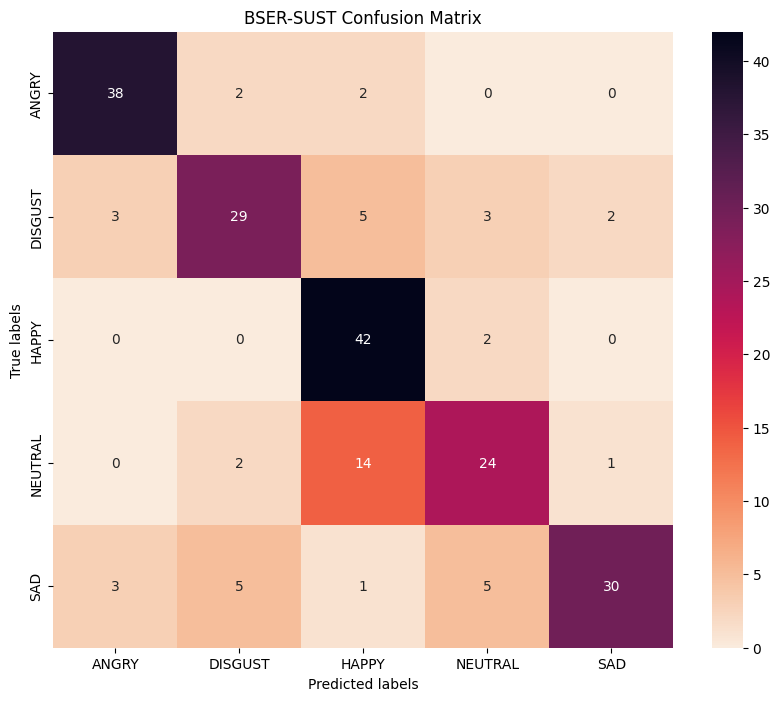

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(csv_path):
    # Load the confusion matrix from CSV
    confusion_matrix = pd.read_csv(csv_path, header=None).values

    # Define the labels for the confusion matrix
    labels = ['ANGRY', 'DISGUST', 'HAPPY', 'NEUTRAL', 'SAD']
    
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='rocket_r', xticklabels=labels, yticklabels=labels)
    
    # Add labels, title and axes
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('BSER-SUST Confusion Matrix')
    plt.show()

# Example usage
csv_path = './data/SUST/data/BSER-SUST_confusion.csv'
plot_confusion_matrix(csv_path)
